## Initial value problems

Here we solve $\frac{dx}{dt} = f(x,t)$ with initial condition $x(t_0)=x_0$.

We'll write a Euler method that's even simpler than the book's.

In [1]:
function myeuler(df, t0, x0, h, n) # derivative, initial conditions, step size, number of steps
    t = t0 .+ h .* (0:n)
    f = zeros(Float64, n+1)
    f[1] = x0
    for i in 1:n
        f[i+1] = f[i] + df(f[i]) * h
    end
    t, f
end

myeuler (generic function with 1 method)

In [2]:
df(x) = x
t1, f1 = myeuler(df, 0, 2, 0.1, 10)


(0.0:0.1:1.0, [2.0, 2.2, 2.4200000000000004, 2.6620000000000004, 2.9282000000000004, 3.22102, 3.5431220000000003, 3.8974342, 4.2871776200000005, 4.715895382, 5.1874849202])

In [3]:
using Plots

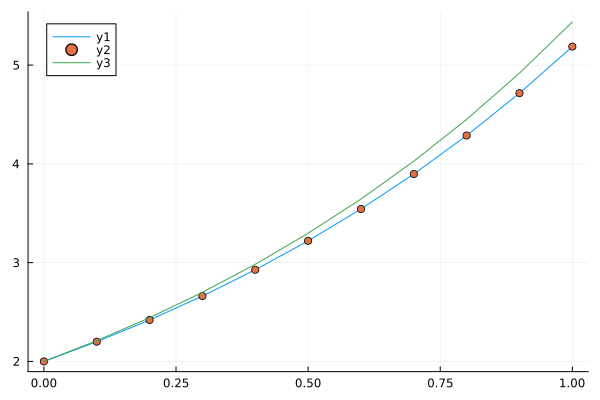

In [4]:
plot(t1, f1)
scatter!(t1, f1)
plot!(t1, 2 .* exp.(t1))

## Systems of IVPs

We can easily extend this to systems of IVPs and higher-order IVPs (section 6.3). A second, third (etc.) order IVP with a second, third, etc., deriviative can be converted to a system of first order IVPs.

The Euler method can be used to solve the system as a straightforward extension.

Example: $x'' + mx' + k x = 0$

Let $y = x'$ so that $y' = x''$. The two equations are now $x' = y$ and $y' = - my - kx$.

This system describes a simple harmonic (linear) oscillator (pendulum, spring, etc.) with position $x$ and momentum proportional to $y$.

We'll solve this first using the DifferentialEquations package.

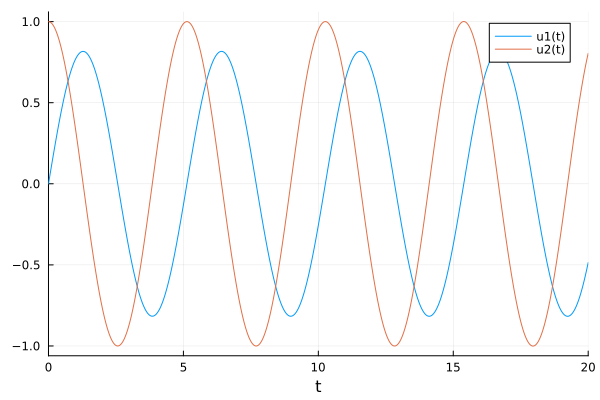

In [8]:
using DifferentialEquations
function oscillator(u, p, t)
    m, k = p # parameters
    x, y = u # dependent variables
    [ y, -m*y - k*x ]
end
u0 = [0.0, 1.0]
tspan = (0.0, 20.0)
p = [0.0, 1.5] # k, m
ivp = ODEProblem(oscillator, u0, tspan, p)
sol = solve(ivp, Tsit5());
plot(sol)

Show the solution in the phase plane (x, y) with time evolving along trajectories.

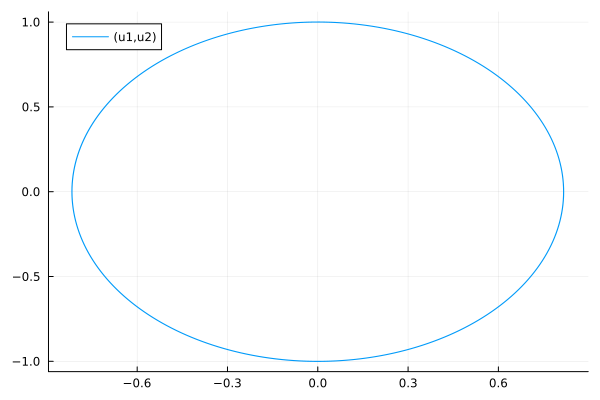

In [9]:
plot(sol, idxs = (1,2))

Let's modify our Euler function to solve a system of first order equations. `x_0` will now be a vector and `df` will take vector iputs and give a vector of outputs.

It's not as general as the version in the text -- we don't make it easy to change parameters in the IVP or allow the right hand side to depend on t. It's almost exactly the same as the previous version.

In [13]:
function myeuler_system(df, t0, x0, h, n)
    t = t0 .+ h .* (0:n)
    f = zeros(Float64, (n+1, length(x0)))
    f[1, :] = x0
    for i in 1:n
        f[i+1, :] = f[i, :] .+ df(f[i, :]) .* h
    end
    t, f
end

myeuler_system (generic function with 1 method)

In [14]:
# predator prey model
function df(u)
    α,β = 0.1, 0.25
    y,z = u      # rename solution components
    s = (y*z) / (1+β*y)     # appears in both equations
    return [ y*(1-α*y) - s, -z + s ]
end;

In [15]:
t2, f2 = myeuler_system(df, 0, [1, 0.01], 0.05, 1200)

(0.0:0.05:60.0, [1.0 0.01; 1.0446 0.0099; … ; 3.1413256870900144 5.20656447623794; 2.7909997153972887 5.404288873111412])

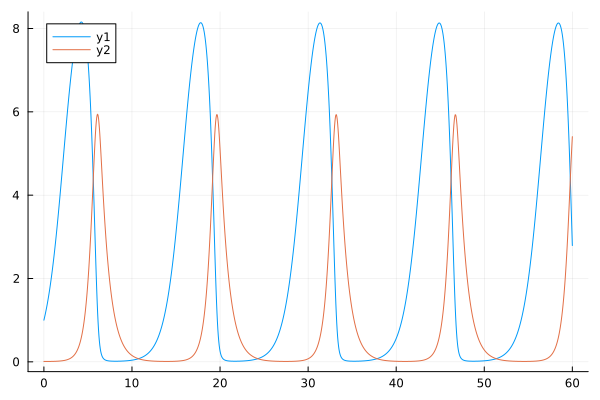

In [16]:
plot(t2, f2[:,1])
plot!(t2, f2[:,2])

Beautiful!

Let's compare these solutions to results from the DifferentialEquations package.

In [11]:
using DifferentialEquations

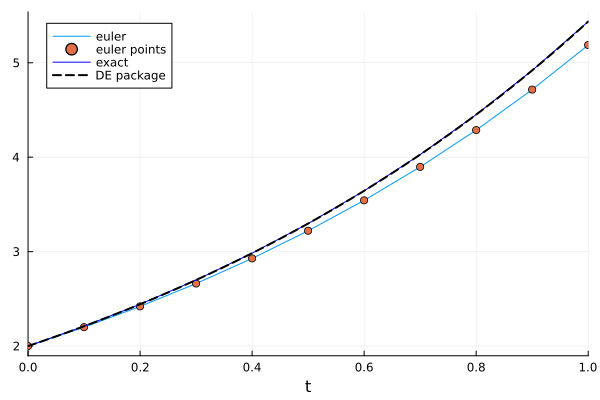

In [10]:
f3 = (u,p,t) -> u;
tspan = (0.0,1.0);
u0 = 2.0;

ivp = ODEProblem(f3, u0, tspan)
u_exact = solve(ivp, Tsit5(), reltol=1e-14, abstol=1e-14)

plot(t1, f1, label = "euler")  # my euler solution
scatter!(t1, f1, label = "euler points")
plot!(t1, 2 .* exp.(t1), line=(1, :blue), label = "exact")
plot!(u_exact, line=(2, :black, :dash), label="DE package") # DifferentialEquations solution

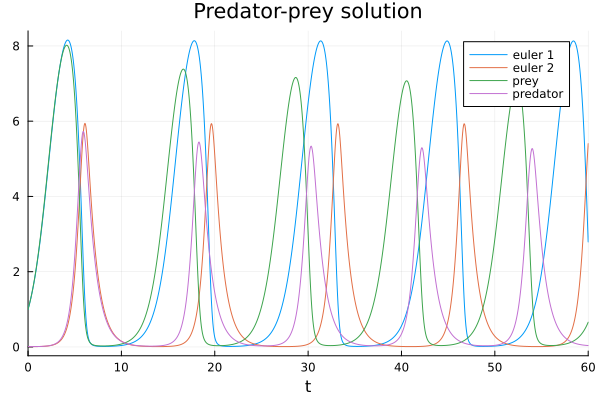

In [17]:
function predprey(u,p,t)
    α,β = p      # rename parameters for convenience
    y,z = u      # rename solution components
    s = (y*z) / (1+β*y)     # appears in both equations
    return [ y*(1-α*y) - s, -z + s ]
end;
u₀ = [1,0.01]
tspan = (0.,60.)
α,β = 0.1,0.25

ivp = ODEProblem(predprey,u₀,tspan,[α,β])
sol = solve(ivp,Tsit5());

plot(t2, f2[:,1], label = "euler 1") # my euler solution
plot!(t2, f2[:,2], label = "euler 2")
plot!(sol,label=["prey" "predator"],title="Predator-prey solution") # DifferentialEquations solution

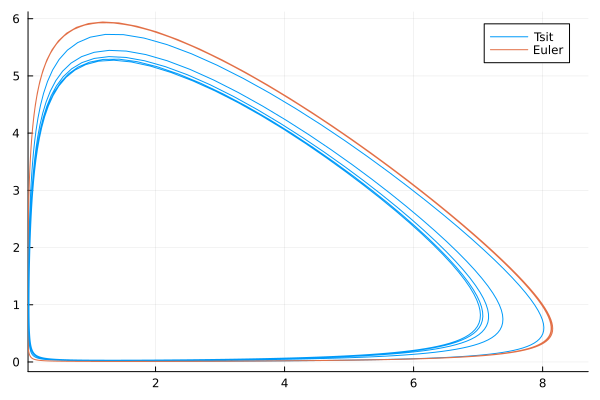

In [18]:
# phase plane
plot(sol, idxs = (1,2), label = "Tsit")
plot!(f2[:,1], f2[:,2], label = "Euler")

Our simple Euler method "works" -- we get solutions, but they become very inaccurate very quickly.

Make $h$ smaller to see if we can track the reference solution well.

## Errors

The error in a single time step is proportional to $h^2$ (Taylor's theorem, Equation 6.2.4 in text.)

Over time, the numerical solution diverges exponentially from the true solution. This is not a precise prediction, since the error may grow more slowly over time depending on the form of the differntial equation.

Let's see both of these errors in a simple example.

$$x'(t) = \lambda x$$

with solution

$$x(t) = x(0)e^{\lambda t}$$

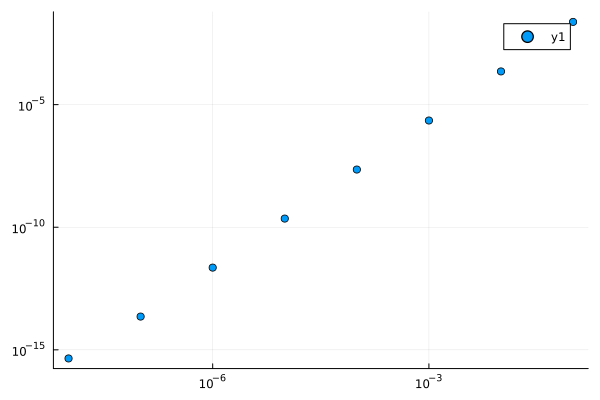

In [19]:
# compute one time step for a range of h
h = 10.0 .^ -(1:8)
x0 = 2.0
lambda = 1.5
f(x, lambda) = lambda * x
x1 = x0 .+ h .* f(x0, lambda)
x1exact = x0 * exp.(lambda .* h)
scatter(h, abs.(x1 .- x1exact), xscale = :log10, yscale = :log10) # quadratic in h

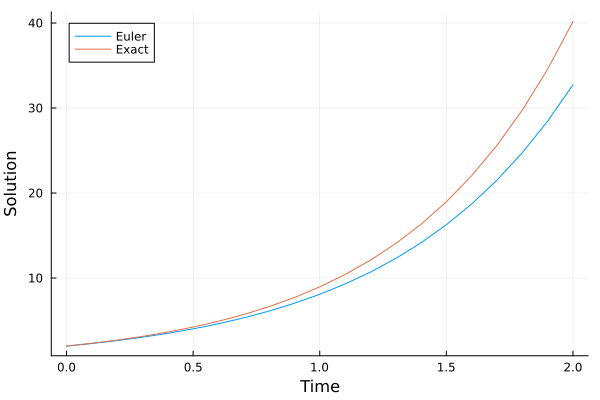

In [24]:
# compute many time steps and compare with true solution
t1, f1 = myeuler(x -> lambda * x, 0, x0, 0.1, 20)
error = abs.(f1 .- x0 * exp.(lambda .* t1))
plot(t1, f1, label = "Euler", xlabel = "Time", ylabel = "Solution")
plot!(t1, x0 * exp.(lambda .* t1), label = "Exact")

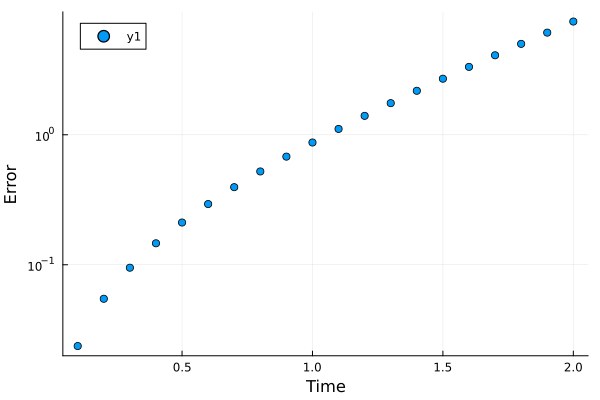

In [25]:
scatter(t1[2:end], error[2:end], yscale = :log10, ylabel = "Error", xlabel = "Time" )